In [1]:
REPO = "diligencefrozen/dcinside-data"
BRANCH = "main"

import sys, pathlib, os
ROOT = pathlib.Path("/content") / REPO.split("/")[-1]

if not ROOT.exists():
    !git clone -b {BRANCH} https://github.com/diligencefrozen/dcinside-data.git "{ROOT}"
%cd "{ROOT}"
!git pull

# src를 sys.path에 추가 (노트북이 어디서 열려도 동작)
cur = pathlib.Path.cwd()
for p in [cur, *cur.parents]:
    if (p/"src").exists():
        sys.path.insert(0, str(p/"src"))
        break

from paths import DATA, ZIP, MAIN, CLEAN, CLEAN_OKT
print("DATA =", DATA)


Cloning into '/content/dcinside-data'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 168 (delta 50), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (168/168), 54.01 MiB | 13.47 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/dcinside-data
Already up to date.
DATA = /content/dcinside-data/data


In [2]:
!wget -O "{ZIP}" https://codeload.github.com/diligencefrozen/dcinside-data/zip/refs/heads/main
!ls -lh "{ZIP}"


--2025-08-10 15:52:16--  https://codeload.github.com/diligencefrozen/dcinside-data/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/dcinside-data/data/dcinside-data-main.zip’

/content/dcinside-d     [          <=>       ]  53.84M  12.4MB/s    in 4.4s    

2025-08-10 15:52:21 (12.4 MB/s) - ‘/content/dcinside-data/data/dcinside-data-main.zip’ saved [56459832]

-rw-r--r-- 1 root root 54M Aug 10 15:52 /content/dcinside-data/data/dcinside-data-main.zip


In [3]:
# Colab/리눅스: 한글 폰트 자동 설치+세팅 (src/korean_setup.py 사용)
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd() / "src"))

from korean_setup import bootstrap_korean
print(bootstrap_korean())


{'font_path': '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', 'family': 'NanumGothic', 'ok': True}


In [4]:
!pip -q install pandas pyarrow konlpy kiwipiepy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 40.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 110.0 MB/s eta 0:00:00


In [5]:
import sys, os
from pathlib import Path
import pandas as pd

def repo_root() -> Path:
    cur = Path.cwd()
    for p in [cur, *cur.parents]:
        if (p / "src").exists():
            return p
    return Path.cwd()

ROOT = repo_root()
sys.path.append(str(ROOT / "src"))

DATA = ROOT / "data"
NB   = ROOT / "notebooks"
DATA.mkdir(exist_ok=True)

MAIN      = DATA / "main.csv"
CLEAN     = DATA / "main_clean.csv"
CLEAN_OKT = DATA / "main_clean_okt.parquet"

FALLBACK_CANDS = [
    NB / "main.csv",
    DATA / "notebooks" / "main.csv",  # 실수로 이렇게 만들었을 가능성
]

def ensure_inputs(okt: bool = False, force: bool = False):
    try:
        from pipeline import ensure_all   # 우리가 만든 파이프라인 유틸
        ensure_all(okt=okt, force=force)  # data/ 밑에 main.csv, main_clean.csv 생성
    except Exception as e:
        print("[warn] pipeline.ensure_all 호출 실패:", e)
        # pipeline 모듈이 없으면 최소한 build_main + preprocess로 대체
        try:
            from build_main import build_main
            from preprocess import attach_clean_tokens
            df = build_main(data_dir=str(DATA), out_csv=str(MAIN))
            df = attach_clean_tokens(df)
            df.to_csv(CLEAN, index=False)
        except Exception as e2:
            raise RuntimeError("입력 생성에 실패했습니다. main.ipynb를 먼저 실행해 main.csv를 만들어 주세요.") from e2

# --- 읽기 우선순위: CLEAN_OKT → CLEAN → MAIN(+fallbacks) ---
def smart_read():
    if CLEAN_OKT.exists():
        return pd.read_parquet(CLEAN_OKT)
    if CLEAN.exists():
        for enc in ("utf-8", "utf-8-sig", "cp949", "euc-kr"):
            try:
                return pd.read_csv(CLEAN, encoding=enc)
            except Exception:
                pass
        return pd.read_csv(CLEAN, encoding_errors="ignore")
    if MAIN.exists():
        for enc in ("utf-8", "utf-8-sig", "cp949", "euc-kr"):
            try:
                return pd.read_csv(MAIN, encoding=enc)
            except Exception:
                pass
        return pd.read_csv(MAIN, encoding_errors="ignore")

    # main.csv가 표준 위치에 없다면 후보 경로도 확인
    for p in FALLBACK_CANDS:
        if p.exists():
            for enc in ("utf-8", "utf-8-sig", "cp949", "euc-kr"):
                try:
                    return pd.read_csv(p, encoding=enc)
                except Exception:
                    pass
            return pd.read_csv(p, encoding_errors="ignore")

    # 여기까지 없으면 생성 시도
    ensure_inputs(okt=False, force=False)
    # 생성 후 다시 시도
    if CLEAN.exists():
        for enc in ("utf-8", "utf-8-sig", "cp949", "euc-kr"):
            try:
                return pd.read_csv(CLEAN, encoding=enc)
            except Exception:
                pass
        return pd.read_csv(CLEAN, encoding_errors="ignore")
    if MAIN.exists():
        for enc in ("utf-8", "utf-8-sig", "cp949", "euc-kr"):
            try:
                return pd.read_csv(MAIN, encoding=enc)
            except Exception:
                pass
        return pd.read_csv(MAIN, encoding_errors="ignore")

    raise FileNotFoundError("main.csv / main_clean.csv를 찾거나 생성하지 못했습니다. main.ipynb 실행을 확인하세요.")

# ---- 실제 로드 ----
df = smart_read()
print("rows:", len(df), "| cols:", list(df.columns)[:10])


rows: 204728 | cols: ['번호', '제목', '제목url', '댓글', '글쓴이', '글쓴이ip', '조회', '추천', '상세시간', '내용']


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

# paths.py가 있다면 사용, 없으면 안전한 폴백
try:
    from paths import DATA, MAIN, CLEAN, CLEAN_OKT
except Exception:
    ROOT = Path.cwd()
    DATA = (ROOT / "data"); DATA.mkdir(exist_ok=True)
    MAIN = DATA / "main.csv"
    CLEAN = DATA / "main_clean.csv"
    CLEAN_OKT = DATA / "main_clean_okt.parquet"  # 이번 단계 출력물 기본값

# 읽기 우선순위: 정제본 -> 원본
read_target = CLEAN if CLEAN.exists() else MAIN
assert read_target.exists(), f"입력 파일이 없습니다: {read_target}"

def _smart_read_csv(p: Path) -> pd.DataFrame:
    for enc in ("utf-8", "utf-8-sig", "cp949", "euc-kr"):
        try:
            return pd.read_csv(p, encoding=enc)
        except Exception:
            continue
    # 마지막 시도: pandas 추론
    return pd.read_csv(p, encoding_errors="ignore")

df = _smart_read_csv(read_target)
print("rows:", len(df), "| cols:", list(df.columns)[:10])


rows: 204728 | cols: ['번호', '제목', '제목url', '댓글', '글쓴이', '글쓴이ip', '조회', '추천', '상세시간', '내용']


In [7]:
import re
from typing import List


def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = re.sub(r"-\s*dc\s+official\s+app", " ", s, flags=re.I)
    s = re.sub(r"From\s+DC\s+Wave", " ", s, flags=re.I)
    s = re.sub(r"이미지\s*순서\s*ON\d*", " ", s, flags=re.I)
    s = re.sub(r"https?://\S+", " ", s)          # URL 제거
    s = re.sub(r"<[^>]+>", " ", s)               # HTML 조각 제거
    s = re.sub(r"(ㅋ)\1{2,}", r"\1\1", s)        # ㅋㅋㅋㅋ → ㅋㅋ
    s = re.sub(r"(ㅎ)\1{2,}", r"\1\1", s)        # ㅎㅎㅎㅎ → ㅎㅎ
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 금칙어
STOP = set(["그냥","근데","그리고","그래서","이런","저런","진짜","정말","오늘","지금","너무"])

# 한글 2글자 이상만 추출
_KOREAN_RE = re.compile(r"[가-힣]{2,}")
def tokenize_regex(s: str) -> List[str]:
    s = clean_text(s)
    toks = _KOREAN_RE.findall(s)
    return [t for t in toks if t not in STOP]

# (B) Okt: 명사 + 동사/형용사 원형(어간) 기준
from konlpy.tag import Okt
_okt = Okt()
def tokenize_okt(s: str) -> List[str]:
    s = clean_text(s)

    morphs = _okt.pos(s, norm=True, stem=True)
    keep = []
    for tok, tag in morphs:
        if tag in ("Noun","Verb","Adjective"):
            tok = tok.strip()
            if len(tok) >= 2 and tok not in STOP:
                keep.append(tok)
    return keep


from kiwipiepy import Kiwi
_kiwi = Kiwi()
def tokenize_kiwi(s: str) -> List[str]:
    s = clean_text(s)
    # Kiwi는 문장 단위 형태소 분석
    res = _kiwi.analyze(s, top_n=1)
    keep = []
    if res:
        for (form, tag, _, _, _) in res[0][0]:
            if tag.startswith(("NN","VV","VA")):  # 명사/동사/형용사
                form = form.strip()
                if len(form) >= 2 and form not in STOP:
                    keep.append(form)
    return keep


In [8]:
pip -q install kiwipiepy tqdm pyarrow

In [16]:
# !pip -q install kiwipiepy tqdm pyarrow

import os, sys, math, pandas as pd, numpy as np
from pathlib import Path
from tqdm import tqdm

# 0) 어떤 텍스트로 토크나이즈할지 준비 (본문+제목)
body_col = "내용" if "내용" in df.columns else None
title_col = "제목" if "제목" in df.columns else None
assert body_col or title_col, "토큰화할 텍스트 열(내용/제목)이 없습니다."

text = (
    (df[body_col].fillna("") if body_col else pd.Series([""]*len(df))) + " " +
    (df[title_col].fillna("") if title_col else pd.Series([""]*len(df)))
).astype(str)

# 1) 클린 & 한글 최소 필터 (형태소 호출 자체를 줄여 속도 ↑)
import re
def clean_text(s: str) -> str:
    s = re.sub(r"-\s*dc\s+official\s+app", " ", s, flags=re.I)
    s = re.sub(r"From\s+DC\s+Wave", " ", s, flags=re.I)
    s = re.sub(r"이미지\s*순서\s*ON\d*", " ", s, flags=re.I)
    s = re.sub(r"https?://\S+", " ", s)
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"(ㅋ)\1{2,}", r"\1\1", s)
    s = re.sub(r"(ㅎ)\1{2,}", r"\1\1", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

has_korean = re.compile(r"[가-힣]{2,}")

STOP = set(["그냥","근데","그리고","그래서","이런","저런","진짜","정말","오늘","지금","너무","나오","통합","모르","올리","연고티비하나누나이뻐요","이렇","아렌","그렇"])

# 2) Kiwi 빠른 모드 토크나이저
from kiwipiepy import Kiwi
def _kiwi_tokenize_fast(s: str):
    s = clean_text(s)
    if not has_korean.search(s):
        return []  # 한글 없으면 스킵
    # analyze()보다 tokenize()가 더 가벼움
    toks = _KIWI.tokenize(s)
    keep = []
    for tk in toks:
        tag = tk.tag  # 'NNG', 'VV', 'VA', ...
        if tag.startswith(("NN","VV","VA")):
            f = tk.form.strip()
            if len(f) >= 2 and f not in STOP:
                keep.append(f)
    return keep

# 3) 중복 텍스트를 한 번만 토큰화
codes, uniques = pd.factorize(text, sort=False)  # codes: 각 행→고유문장 인덱스
uniq_texts = pd.Series(uniques)

# 4) 병렬 처리 (코랩 CPU 코어 수만큼). Kiwi 객체는 프로세스마다 생성.
from multiprocessing import Pool, cpu_count

def _init_worker():
    global _KIWI
    _KIWI = Kiwi()  # 프로세스별 초기화

def _work(s):
    return _kiwi_tokenize_fast(s)

use_procs = max(1, min(4, cpu_count() or 1))  # 코랩은 대개 2~4코어
print(f"Using processes: {use_procs}")

if use_procs > 1:
    with Pool(processes=use_procs, initializer=_init_worker) as pool:
        uniq_tokens = list(tqdm(pool.imap(_work, uniq_texts), total=len(uniq_texts),
                                desc="Tokenize(unique)"))
else:
    _init_worker()
    uniq_tokens = [ _work(s) for s in tqdm(uniq_texts, desc="Tokenize(unique)") ]

# 5) 원래 행 순서대로 복원
tokens = [ uniq_tokens[c] if c >= 0 else [] for c in codes ]

df_out = df.copy()
df_out["tokens"] = tokens
print(df_out[["tokens"]].head())


Using processes: 4


Tokenize(unique): 100%|██████████| 187902/187902 [01:22<00:00, 2272.33it/s]


                                              tokens
0                     [엘사, 도찐개찐, 다르, 의미, 싸우, 필요, 내리]
1  [사고, 다치, 어깨, 쑤시, 저녁, 뻐근하, 이불, 들어가, 감기, 몸살, 걸리,...
2           [저장소, 바꾸, 바람, 쫓겨나, 오가, 신세, 겨벤갤, 아지트, 사또]
3                              [사지, 앙졸이, 만나, 초면, 반말]
4                                   [엘사, 격하, 갈드, 성립]


In [17]:
# === 0) 토크나이저 모드 지정 ===
MODE = "kiwi"   # or "okt" / "regex"

# === 1) DATA 경로 확보 ===
from pathlib import Path
try:
    from paths import DATA
except Exception:
    DATA = Path.cwd() / "data"
    DATA.mkdir(exist_ok=True)

# === 2) df_out 준비 (앞 셀에서 만든 df_out이 없다면 생성) ===
import pandas as pd
if "df_out" not in locals():
    assert "df" in locals() and "tokens" in locals(), "df_out이 없으면 df와 tokens가 필요합니다."
    df_out = df.copy()
    df_out["tokens"] = tokens

# === 3) 저장 경로 만들기 ===
out_parquet     = DATA / f"main_tokens_{MODE}.parquet"
out_tokens_csv  = DATA / f"top_tokens_{MODE}.csv"
out_bigrams_csv = DATA / f"top_bigrams_{MODE}.csv"

# === 4) 저장 (parquet은 pyarrow 필요) ===
# !pip -q install pyarrow  # 에러나면 주석 해제하고 실행
df_out.to_parquet(out_parquet, index=False)

# === 5) 토큰/바이그램 빈도 집계 ===
from collections import Counter
import itertools

uni = Counter(itertools.chain.from_iterable(df_out["tokens"]))
top_tokens = pd.DataFrame(uni.most_common(2000), columns=["token", "count"])

bi = Counter()
for ts in df_out["tokens"]:
    for a, b in zip(ts, ts[1:]):
        bi[(a, b)] += 1
top_bigrams = pd.DataFrame([(" ".join(k), v) for k, v in bi.most_common(2000)],
                           columns=["bigram", "count"])

top_tokens.to_csv(out_tokens_csv, index=False)
top_bigrams.to_csv(out_bigrams_csv, index=False)

print("saved:")
print(" -", out_parquet)
print(" -", out_tokens_csv)
print(" -", out_bigrams_csv)


saved:
 - /content/dcinside-data/data/main_tokens_kiwi.parquet
 - /content/dcinside-data/data/top_tokens_kiwi.csv
 - /content/dcinside-data/data/top_bigrams_kiwi.csv


In [18]:
pip -q install wordcloud

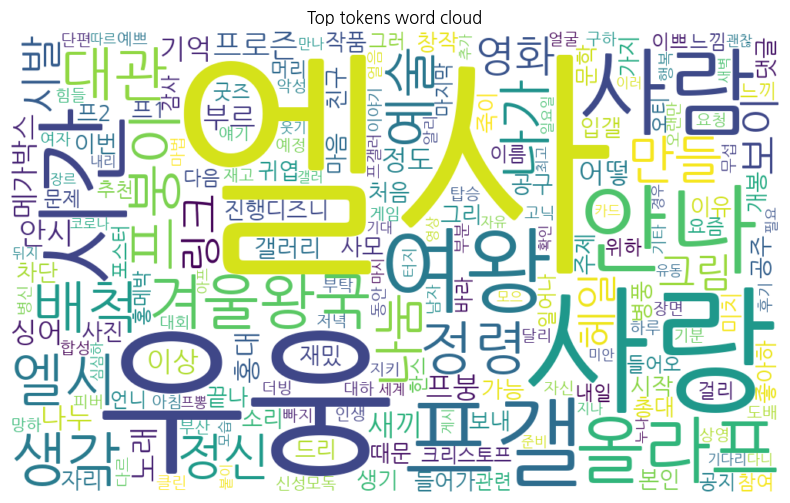

In [19]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# 1) 폰트 경로 확보
font_path = None
try:
    from korean_setup import wordcloud_font_path
    font_path = wordcloud_font_path()
except Exception:
    from matplotlib import font_manager as fm
    cands = [p for p in fm.findSystemFonts() if ("Nanum" in p or "NotoSansCJK" in p or "NotoSansCJK" in p)]
    font_path = cands[0] if cands else None

# 2) 토큰 빈도 (df_out['tokens'] 사용)
assert "df_out" in globals() and "tokens" in df_out.columns, "df_out['tokens']가 필요합니다."
freq = Counter(t for row in df_out["tokens"] for t in row)

# 3) 워드클라우드
from wordcloud import WordCloud

wc = WordCloud(
    width=1000, height=600,
    background_color="white",
    font_path=font_path  # 한글 필수
).generate_from_frequencies(freq)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Top tokens word cloud")
plt.show()
